In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tensornetworks_pytorch.TNModels import PosMPS, Born
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

print(torch.__version__)

1.8.0.dev20201128


In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)
if DEVICE.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0) / 1024**3, 1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0) / 1024**3, 1), 'GB')

Using device: cpu


In [3]:
### import data
import pickle
for dataset in ['biofam','flare','lymphography','spect','tumor','votes']:
    with open('datasets/'+dataset, 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1' # biofam seemed to have an encoding issue which this fixes
        a = u.load()
    X=a[0].astype(int)
    print(f"╭──{dataset}")
    print(f"│ data shape:{X.shape}")
    print(f"│ range of X values: {X.min()} -- {X.max()}")
    print(f"╰───────────────────")
    
def load_dataset(dataset):
    with open('datasets/'+dataset, 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        a = u.load()
    X=a[0]
    X=X.astype(int)
    print(f"╭──{dataset}")
    print(f"│ data shape:{X.shape}")
    print(f"│ range of X values: {X.min()} -- {X.max()}")
    print(f"╰───────────────────")
    d = X.max()+1
    return X, d

def train_models(
        models, batchsize=20, max_epochs=50, 
        batched=False, clamp_at=None, 
        optimizer=torch.optim.Adadelta, **optim_kwargs):
    print(f"dataset: {dataset}")
    models_loss_values={}
    for model in models:
        loss_values = model.train(
            batchsize=batchsize, max_epochs=max_epochs, tqdm=tqdm, plot=False,
            clamp_at=clamp_at, batched=batched,
            optimizer=optimizer, **optim_kwargs)
        plt.plot(loss_values, label=model.name)
        plt.ylabel('avg loss (NLL)')
        plt.xlabel('Epoch')
        plt.title(f"dataset: {dataset} (d={d}), bond dim={D}\n batchsize:{batchsize}, {optimizer.__module__} {optim_kwargs}")
        models_loss_values[f"{model.name}"]=loss_values
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()
    return models_loss_values

╭──biofam
│ data shape:(2000, 16)
│ range of X values: 0 -- 7
╰───────────────────
╭──flare
│ data shape:(1065, 13)
│ range of X values: 0 -- 7
╰───────────────────
╭──lymphography
│ data shape:(148, 19)
│ range of X values: 0 -- 7
╰───────────────────
╭──spect
│ data shape:(187, 23)
│ range of X values: 0 -- 1
╰───────────────────
╭──tumor
│ data shape:(339, 17)
│ range of X values: 0 -- 3
╰───────────────────
╭──votes
│ data shape:(435, 17)
│ range of X values: 0 -- 2
╰───────────────────


In [14]:
### initialize models
dataset = 'tumor'
X,d = load_dataset(dataset)
D = 8

wr = noisy # choose either None, 'noisy', or 'random_angle' or 'gaussian_zeros'

mps      = PosMPS(X, d, D,                     homogeneous=False, log_stability=False,  w_randomization=wr)
mps_hom  = PosMPS(X, d, D,                     homogeneous=True,  log_stability=False,  w_randomization=wr)
mps_s    = PosMPS(X, d, D,                     homogeneous=False, log_stability=True,   w_randomization=wr)
mps_s_hom= PosMPS(X, d, D,                     homogeneous=True,  log_stability=True,   w_randomization=wr)
rBorn      = Born(X, d, D, dtype=torch.float,  homogeneous=False, log_stability=False,  w_randomization=wr) 
rBorn_hom  = Born(X, d, D, dtype=torch.float,  homogeneous=True,  log_stability=False,  w_randomization=wr)
rBorn_s    = Born(X, d, D, dtype=torch.float,  homogeneous=False, log_stability=True,   w_randomization=wr)
rBorn_s_hom= Born(X, d, D, dtype=torch.float,  homogeneous=True,  log_stability=True,   w_randomization=wr)
cBorn      = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=False,  w_randomization=wr)
cBorn_hom  = Born(X, d, D, dtype=torch.cfloat, homogeneous=True,  log_stability=False,  w_randomization=wr)
cBorn_s    = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=True,   w_randomization=wr)
cBorn_s_hom= Born(X, d, D, dtype=torch.cfloat, homogeneous=True,  log_stability=True,   w_randomization=wr)

models     = (
    # rBorn, cBorn, mps, 
    rBorn_s, cBorn_s, mps_s)
models_hom = (
    # rBorn_hom, cBorn_hom, mps_hom, 
    rBorn_s_hom, cBorn_s_hom, mps_s_hom)

def clip_grad(grad, clip_val, param_name, verbose=False):
    """Clip the gradients, to be used as a hook during training."""
    if torch.isnan(grad).any():
        print(f"├─NaN value in gradient of {param_name}, {grad.size()}")
    if grad.dtype==torch.cfloat:
        for ext, v in [("min", grad.real.min()),("max", grad.real.max())]:
            if verbose and abs(v) > clip_val:
                print(f"│(clipping {param_name} real {ext} {v:.2} to size {clip_val})")
        for ext, v in [("min", grad.imag.min()),("max", grad.imag.max())]:
            if verbose and abs(v) > clip_val:
                print(f"│(clipping {param_name} imag {ext} {1.j*v:.2} to size {clip_val})")
        clipped_grad = torch.complex(grad.real.clamp(-clip_val, clip_val),
                                     grad.imag.clamp(-clip_val, clip_val))
    else:
        for ext, v in [("min", grad.min()),("max", grad.max())]:
            if verbose and abs(v) > clip_val:
                print(f"│(clipping {param_name} {ext} {v:.2} to size {clip_val})")
        clipped_grad = torch.clamp(grad, -clip_val, clip_val)
    return clipped_grad

print(f"Models: D={D}, d={d}")
for model in (*models, *models_hom):
    print(f"\t{model.core.shape} model type: {model.name}")
    for param_index, p in enumerate(model.parameters()):
        pnames = list(model.state_dict().keys())
        p.register_hook(lambda grad: clip_grad(grad, 1000, pnames[param_index], verbose=True))
        if torch.isnan(p).any():
            print(f"{pnames[param_index]} contains a NaN value!")

╭──tumor
│ data shape:(339, 17)
│ range of X values: 0 -- 3
╰───────────────────
Models: D=8, d=4
	torch.Size([17, 4, 8, 8]) model type: Born (torch.float32), Non-homogeneous + log_stability
	torch.Size([17, 4, 8, 8]) model type: Born (torch.complex64), Non-homogeneous + log_stability
	torch.Size([17, 4, 8, 8]) model type: Positive MPS, Non-homogeneous + log_stability
	torch.Size([4, 8, 8]) model type: Born (torch.float32), Homogeneous + log_stability
	torch.Size([4, 8, 8]) model type: Born (torch.complex64), Homogeneous + log_stability
	torch.Size([4, 8, 8]) model type: Positive MPS, Homogeneous + log_stability


dataset: tumor
╭───────────────────────────
│Training Born (torch.float32), Non-homogeneous + log_stability, on cpu
│         batchsize:10, torch.optim.adam, {'lr': 0.001}.



│ loss values: 17.453 11.125 10.222 10.134 10.091 10.036 9.992 9.954 9.920 9.875 9.805 9.715 9.637 9.585 9.523 9.496 9.451 9.426 9.383 9.358 9.338 9.305 9.281 9.275 9.245 9.214 9.208 9.173 9.155 9.140 9.116 9.108 9.084 9.061 9.038 8.995 8.938 8.876 8.830 8.821 8.804 8.781 8.783 8.777 8.761 8.751 8.722 8.707 8.698 8.692 8.668 8.655 8.628 8.611 8.582 8.534 8.527 8.503 8.481 8.463 8.439 8.436 8.419 8.396 8.386 8.372 8.355 8.354 8.339 8.319 8.295 8.291 8.271 8.267 8.237 8.227 8.212 8.210 8.211 8.196 8.175 8.154 8.152 8.140 8.144 8.128 8.114 8.118 8.098 8.089 8.087 8.068 8.061 8.055 8.038 8.045 8.017 8.003 8.005 8.002 7.983 7.985 7.967 7.967 7.960 7.962 7.944 7.930 7.930 7.923 7.908 7.906 7.904 7.887 7.891 7.869 7.864 7.864 7.857 7.843 7.837 7.833 7.830 7.827 7.811 7.809 7.799 7.790 7.791 7.777 7.760 7.749 7.751 7.742 7.734 7.726 7.722 7.720 7.705 7.706 7.704 7.691 7.680 7.677 7.661 7.654 7.654 7.642 7.641 7.637 7.632 7.628 7.622 7.616 7.604 7.610 7.602 7.588 7.581 7.577 7.579 7.566 7.567 


│ loss values: 17.464 11.121 10.226 10.120 10.084 10.029 9.987 9.950 9.916 9.875 9.846 9.814 9.776 9.755 9.719 9.690 9.668 9.631 9.605 9.585 9.567 9.549 9.512 9.499 9.465 9.451 9.431 9.410 9.375 9.337 9.279 9.221 9.166 9.117 9.077 9.044 9.007 8.949 8.899 8.829 8.791 8.747 8.735 8.711 8.685 8.672 8.664 8.636 8.613 8.607 8.601 8.566 8.532 8.513 8.492 8.465 8.442 8.435 8.410 8.385 8.366 8.340 8.326 8.313 8.283 8.265 8.243 8.245 8.217 8.206 8.207 8.172 8.159 8.152 8.141 8.124 8.109 8.112 8.088 8.074 8.061 8.062 8.049 8.033 8.029 8.027 8.011 8.001 7.987 7.976 7.967 7.964 7.963 7.942 7.942 7.939 7.916 7.915 7.900 7.887 7.878 7.877 7.865 7.860 7.850 7.848 7.837 7.837 7.833 7.817 7.808 7.804 7.796 7.788 7.789 7.776 7.766 7.758 7.737 7.741 7.735 7.725 7.718 7.721 7.714 7.696 7.689 7.684 7.680 7.676 7.662 7.650 7.648 7.643 7.636 7.630 7.643 7.626 7.619 7.609 7.597 7.596 7.593 7.588 7.580 7.565 7.557 7.565 7.547 7.549 7.550 7.537 7.530 7.530 7.516 7.516 7.507 7.504 7.505 7.492 7.479 7.484 7.473 


│ loss values: 18.319 14.256 14.115 14.026 13.949 13.876 13.766 13.616 13.436 13.265 13.116 12.933 12.760 12.623 12.541 12.483 12.440 12.407 12.377 12.367 12.326 12.303 12.282 12.252 12.219 12.190 12.160 12.123 12.082 12.042 12.025 11.972 11.966 11.947 11.908 11.868 11.831 11.807 11.756 11.703 11.642 11.526 11.282 10.875 10.634 10.534 10.451 10.395 10.343 10.330 10.354 10.268 10.221 10.185 10.119 10.057 10.045 9.878 9.798 9.726 9.685 9.648 9.617 9.561 9.684 9.559 9.463 9.435 9.390 9.363 9.321 9.289 9.255 9.214 9.166 9.127 9.084 9.031 8.974 8.923 8.888 8.865 8.831 8.814 8.802 8.794 8.757 8.745 8.716 8.695 8.684 8.673 8.671 8.652 8.645 8.633 8.619 8.608 8.591 8.595 8.581 8.552 8.532 8.510 8.495 8.488 8.465 8.461 8.459 8.439 8.422 8.420 8.421 8.413 8.390 8.384 8.379 8.360 8.366 8.345 8.353 8.343 8.321 8.324 8.319 8.309 8.325 8.290 8.282 8.278 8.265 8.259 8.258 8.248 8.246 8.238 8.221 8.219 8.204 8.202 8.199 8.191 8.191 8.175 8.161 8.153 8.143 8.152 8.134 8.124 8.106 8.099 8.090 8.078 8.0


│ loss values: 18.376 14.264 14.111 14.047 13.977 13.898 13.789 13.626 13.457 13.310 13.173 13.035 12.915 12.825 12.784 12.751 12.698 12.679 12.666 12.634 12.599 12.615 12.548 12.514 12.475 12.414 12.342 12.260 12.212 12.161 12.128 12.083 12.055 12.033 12.011 11.960 11.935 11.888 11.874 11.805 11.763 11.687 11.595 11.451 11.244 10.813 10.175 9.949 10.374 9.858 9.670 9.558 9.493 9.423 9.349 9.305 9.260 9.222 9.207 9.173 9.142 9.128 9.113 9.085 9.089 9.062 9.046 9.025 9.023 8.994 8.990 8.984 8.953 8.958 8.934 8.922 8.919 8.898 8.882 8.867 8.863 8.865 8.832 8.820 8.807 8.797 8.773 8.758 8.746 8.730 8.715 8.682 8.649 8.629 8.624 8.612 8.597 8.571 8.553 8.547 8.522 8.522 8.505 8.499 8.485 8.472 8.479 8.465 8.464 8.472 8.465 8.443 8.420 8.411 8.402 8.400 8.383 8.373 8.369 8.373 8.352 8.352 8.361 8.352 8.326 8.318 8.316 8.296 8.291 8.284 8.290 8.278 8.283 8.276 8.246 8.247 8.238 8.232 8.225 8.220 8.213 8.197 8.197 8.190 8.196 8.165 8.168 8.169 8.184 8.150 8.146 8.140 8.129 8.128 8.113 8.100 

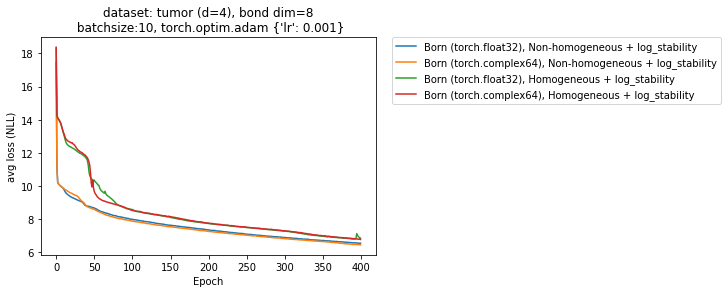

In [12]:
lossvals = train_models(
    [rBorn_s, cBorn_s,rBorn_s_hom, cBorn_s_hom],
    clamp_at=1000, batchsize=10, max_epochs=400, batched=True, optimizer=torch.optim.Adam, lr=0.001)

dataset: tumor
╭───────────────────────────
│Training Born (torch.float32), Non-homogeneous + log_stability, on cpu
│         batchsize:40, torch.optim.adam, {'lr': 0.001}.



│ loss values: 22.161 18.021 15.012 13.030 11.735 10.945 10.554 10.427 10.271 10.124 10.109 10.085 10.048 9.985 10.001 9.971 9.976 10.027 9.961 9.939 9.894 9.902 9.871 9.837 9.843 9.833 9.834 9.822 9.760 9.775 9.744 9.745 9.811 9.769 9.679 9.736 9.789 9.754 9.669 9.617 9.721 9.667 9.687 9.652 9.657 9.653 9.617 9.579 9.567 9.536 9.585 9.661 9.570 9.531 9.552 9.519 9.519 9.462 9.454 9.438 9.532 9.503 9.473 9.461 9.431 9.412 9.431 9.396 9.371 9.453 9.439 9.461 9.373 9.343 9.353 9.403 9.339 9.323 9.327 9.231 9.203 9.216 9.180 9.195 9.186 9.179 9.199 9.174 9.173 9.149 9.182 9.181 9.099 9.114 9.091 9.115 9.164 9.142 9.178 9.101 9.098 9.078 9.055 9.074 9.126 9.034 9.046 9.003 9.025 8.976 9.002 9.027 8.973 9.025 9.001 8.933 8.901 8.958 8.951 8.922 8.884 8.876 8.839 8.895 8.923 8.867 8.845 8.829 8.868 8.818 8.792 8.780 8.765 8.787 8.790 8.843 8.809 8.763 8.782 8.850 8.768 8.792 8.791 8.702 8.743 8.725 8.732 8.739 8.758 8.755 8.711 8.747 8.676 8.716 8.693 8.754 8.645 8.657 8.661 8.676 8.707 8.6


│ loss values: 22.130 18.043 15.014 13.039 11.717 10.998 10.552 10.359 10.172 10.181 10.101 10.084 10.084 10.105 10.069 10.054 10.017 9.996 10.012 9.983 10.034 9.979 9.933 9.989 9.890 9.938 9.947 9.942 9.897 9.874 9.903 9.902 9.921 9.841 9.871 9.794 9.824 9.831 9.893 9.848 9.796 9.775 9.762 9.801 9.779 9.727 9.709 9.771 9.671 9.645 9.704 9.729 9.709 9.707 9.670 9.670 9.662 9.666 9.680 9.643 9.691 9.590 9.619 9.634 9.592 9.621 9.560 9.643 9.536 9.541 9.510 9.592 9.547 9.578 9.451 9.403 9.358 9.371 9.378 9.377 9.365 9.335 9.323 9.327 9.328 9.369 9.335 9.340 9.336 9.335 9.278 9.277 9.297 9.331 9.315 9.286 9.342 9.215 9.309 9.281 9.283 9.249 9.193 9.242 9.249 9.138 9.198 9.205 9.239 9.213 9.231 9.172 9.217 9.161 9.182 9.094 9.142 9.080 9.100 9.051 9.073 9.052 9.009 9.055 8.997 8.994 9.047 9.023 8.984 9.024 8.933 8.993 8.959 8.980 8.885 8.906 8.897 8.911 8.871 8.882 8.933 8.864 8.887 8.845 8.886 8.817 8.801 8.870 8.827 8.890 8.885 8.819 8.858 8.779 8.845 8.768 8.849 8.848 8.761 8.856 8.784


│ loss values: 22.355 18.770 16.412 15.011 14.398 14.268 14.202 14.230 14.216 14.183 14.145 14.140 14.059 14.026 14.079 13.950 14.047 14.037 13.897 14.017 13.831 13.807 13.799 13.695 13.686 13.608 13.611 13.546 13.559 13.562 13.426 13.445 13.377 13.306 13.228 13.203 13.239 13.168 13.030 13.087 13.019 12.933 12.965 12.897 12.900 12.839 12.788 12.706 12.728 12.722 12.653 12.661 12.569 12.543 12.478 12.459 12.428 12.428 12.366 12.304 12.299 12.248 12.279 12.226 12.211 12.175 12.152 12.204 12.161 12.062 12.175 12.076 12.152 12.064 12.074 12.132 12.073 11.976 12.005 11.982 11.994 11.976 11.912 11.972 11.925 11.944 11.877 11.854 11.827 11.865 11.840 11.789 11.767 11.736 11.712 11.685 11.628 11.643 11.607 11.611 11.530 11.571 11.540 11.500 11.432 11.487 11.409 11.395 11.267 11.233 11.177 11.030 10.961 10.697 10.533 10.327 10.094 10.088 9.842 9.768 9.714 9.591 9.536 9.469 9.425 9.370 9.361 9.299 9.323 9.308 9.294 9.261 9.277 9.250 9.223 9.240 9.242 9.213 9.187 9.170 9.218 9.165 9.196 9.158 9.


│ loss values: 22.323 18.758 16.382 15.017 14.399 14.205 14.176 14.208 14.136 14.111 14.151 14.098 14.089 14.099 14.061 14.055 13.975 13.968 13.975 13.854 13.819 13.824 13.743 13.620 13.624 13.572 13.485 13.530 13.449 13.429 13.390 13.300 13.292 13.262 13.204 13.109 13.087 13.049 13.081 12.963 12.904 12.868 12.842 12.710 12.713 12.700 12.619 12.646 12.512 12.531 12.471 12.451 12.472 12.480 12.407 12.425 12.394 12.294 12.324 12.309 12.314 12.190 12.213 12.237 12.226 12.219 12.179 12.187 12.170 12.198 12.126 12.147 12.097 12.112 12.096 12.075 12.017 12.010 12.009 12.040 12.009 11.999 11.975 11.993 11.986 11.962 11.980 11.941 11.973 11.893 11.849 11.891 11.868 11.831 11.857 11.808 11.805 11.729 11.805 11.774 11.726 11.690 11.696 11.646 11.627 11.648 11.621 11.551 11.582 11.572 11.492 11.485 11.464 11.449 11.402 11.343 11.363 11.176 11.111 11.140 10.935 10.777 10.623 10.557 10.380 10.396 10.329 10.360 10.273 10.312 10.356 10.299 10.306 11.174 11.046 10.595 10.441 10.349 10.282 10.265 10.2

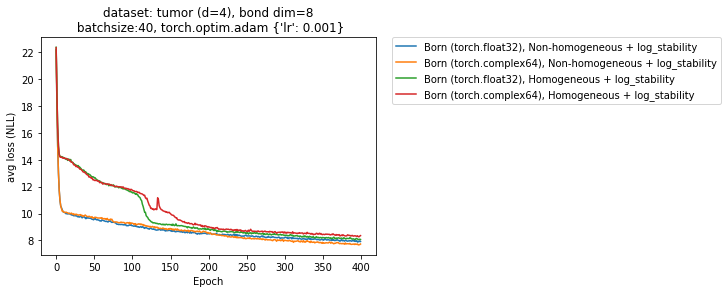

In [15]:
lossvals = train_models(
    [rBorn_s, cBorn_s,rBorn_s_hom, cBorn_s_hom],
    clamp_at=1000, batchsize=40, max_epochs=400, batched=True, optimizer=torch.optim.Adam, lr=0.001)

dataset: tumor
╭───────────────────────────
│Training Positive MPS, Non-homogeneous, on cpu
│         batchsize:10, torch.optim.adam, {'lr': 0.001}.



│ loss values: 16.816 10.536 9.672 9.630 9.637 9.630 9.645 9.637 9.643 9.622 9.642 9.642 9.639 9.640 9.647 9.638 9.633 9.644 9.653 9.646 9.634 9.642 9.648 9.650 9.633 9.641 9.642 9.652 9.638 9.643 9.633 9.636 9.636 9.633 9.632 9.644 9.638 9.635 9.633 9.644 9.645 9.644 9.629 9.638 9.646 9.635 9.636 9.630 9.647 9.636 9.643 9.642 9.629 9.635 9.640 9.627 9.633 9.640 9.633 9.630 9.640 9.643 9.649 9.637 9.637 9.633 9.636 9.631 9.638 9.638 9.637 9.636 9.630 9.640 9.627 9.628 9.634 9.646 9.625 9.636 9.643 9.636 9.634 9.627 9.627 9.631 9.636 9.640 9.634 9.632 9.632 9.639 9.629 9.636 9.636 9.638 9.644 9.637 9.634 9.644 9.633 9.632 9.633 9.625 9.631 9.629 9.638 9.629 9.642 9.652 9.635 9.627 9.626 9.640 9.629 9.634 9.635 9.640 9.628 9.641 9.637 9.629 9.630 9.646 9.632 9.638 9.651 9.628 9.633 9.629 9.632 9.632 9.623 9.622 9.635 9.630 9.628 9.634 9.628 9.631 9.630 9.630 9.646 9.640 9.637 9.629 9.634 9.632 9.631 9.629 9.643 9.626 9.630 9.631 9.624 9.629 9.627 9.626 9.635 9.628 9.630 9.633 9.640 9.63


│ loss values: 17.557 13.657 13.597 13.596 13.607 13.602 13.596 13.610 13.600 13.597 13.598 13.596 13.600 13.603 13.612 13.623 13.605 13.603 13.595 13.601 13.597 13.606 13.597 13.610 13.606 13.601 13.596 13.602 13.596 13.609 13.616 13.603 13.609 13.604 13.602 13.613 13.608 13.596 13.595 13.612 13.589 13.607 13.596 13.602 13.603 13.606 13.613 13.598 13.602 13.600 13.600 13.599 13.604 13.603 13.607 13.599 13.601 13.601 13.602 13.615 13.599 13.605 13.602 13.610 13.596 13.590 13.599 13.595 13.603 13.598 13.601 13.599 13.606 13.603 13.595 13.606 13.610 13.605 13.604 13.597 13.608 13.594 13.607 13.600 13.598 13.600 13.609 13.607 13.604 13.619 13.599 13.601 13.605 13.608 13.599 13.596 13.608 13.588 13.597 13.600 13.604 13.615 13.599 13.600 13.606 13.606 13.598 13.610 13.607 13.604 13.598 13.603 13.600 13.599 13.599 13.601 13.614 13.609 13.600 13.593 13.604 13.604 13.621 13.599 13.599 13.594 13.598 13.604 13.596 13.598 13.601 13.593 13.597 13.599 13.601 13.618 13.607 13.597 13.597 13.601 13.5


│ loss values: 16.828 10.523 9.693 9.635 9.631 9.645 9.642 9.636 9.640 9.645 9.644 9.654 9.631 9.641 9.640 9.644 9.641 9.654 9.642 9.632 9.637 9.639 9.642 9.650 9.649 9.628 9.640 9.640 9.631 9.641 9.632 9.635 9.647 9.638 9.639 9.642 9.648 9.641 9.633 9.652 9.633 9.639 9.630 9.642 9.647 9.656 9.643 9.637 9.643 9.641 9.647 9.663 9.630 9.636 9.641 9.635 9.635 9.637 9.650 9.633 9.638 9.636 9.637 9.642 9.626 9.630 9.625 9.634 9.634 9.655 9.634 9.631 9.640 9.639 9.634 9.642 9.624 9.635 9.628 9.631 9.629 9.638 9.630 9.636 9.639 9.636 9.627 9.632 9.628 9.640 9.644 9.642 9.632 9.635 9.632 9.634 9.638 9.637 9.633 9.631 9.625 9.647 9.633 9.637 9.634 9.633 9.636 9.634 9.629 9.628 9.622 9.629 9.647 9.619 9.637 9.653 9.642 9.633 9.627 9.630 9.634 9.639 9.649 9.635 9.633 9.623 9.625 9.631 9.639 9.638 9.621 9.629 9.638 9.626 9.640 9.634 9.631 9.626 9.622 9.633 9.634 9.627 9.637 9.636 9.640 9.650 9.637 9.627 9.630 9.633 9.632 9.628 9.628 9.625 9.629 9.632 9.626 9.625 9.626 9.633 9.625 9.625 9.625 9.62


│ loss values: 17.737 13.676 13.597 13.596 13.592 13.598 13.615 13.594 13.595 13.595 13.602 13.599 13.597 13.611 13.599 13.602 13.603 13.592 13.595 13.601 13.612 13.602 13.594 13.607 13.608 13.589 13.595 13.595 13.607 13.603 13.609 13.616 13.618 13.595 13.597 13.600 13.592 13.623 13.604 13.597 13.606 13.601 13.602 13.623 13.603 13.598 13.600 13.598 13.588 13.607 13.595 13.604 13.597 13.602 13.602 13.601 13.613 13.600 13.602 13.602 13.601 13.601 13.593 13.603 13.602 13.596 13.603 13.597 13.600 13.594 13.601 13.596 13.597 13.606 13.605 13.595 13.605 13.603 13.599 13.600 13.603 13.608 13.595 13.598 13.600 13.603 13.609 13.605 13.597 13.611 13.613 13.602 13.600 13.591 13.598 13.593 13.609 13.609 13.599 13.608 13.593 13.595 13.599 13.601 13.595 13.596 13.615 13.609 13.604 13.599 13.598 13.605 13.607 13.594 13.592 13.606 13.597 13.600 13.607 13.609 13.601 13.599 13.608 13.606 13.599 13.601 13.596 13.590 13.591 13.599 13.608 13.602 13.602 13.602 13.594 13.594 13.598 13.605 13.601 13.603 13.5

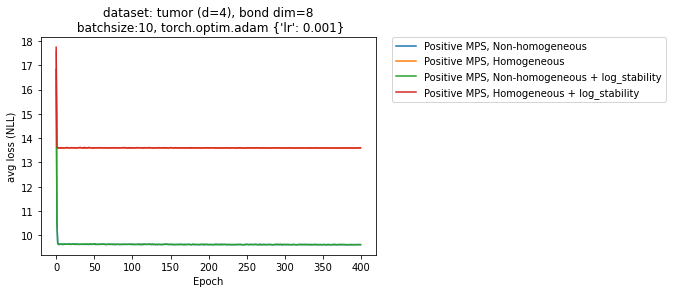

In [16]:
lossvals = train_models(
    [mps, mps_hom, mps_s, mps_s_hom], 
    clamp_at=1000, batchsize=10, max_epochs=400, batched=False, optimizer=torch.optim.Adam, lr=0.001)

In [ ]:
lossvals = train_models(models_hom, batchsize=10, max_epochs=1000, optimizer=torch.optim.Adadelta)

dataset: tumor
╭───────────────────────────
│Training Positive MPS, Non-homogeneous, on cpu
│         batchsize:10, torch.optim.adam, {'lr': 0.001}.



│ loss values: 16.764 10.534 9.672 9.643 9.634 9.639 9.644 9.644 9.647 9.642 9.639 9.639 9.640 9.632 9.648 9.636 9.637 9.645 9.651 9.638 9.641 9.641 9.645 9.645 9.653 9.657 9.644 9.644 9.639 9.639 9.637 9.640 9.633 9.627 9.639 9.634 9.633 9.643 9.632 9.647 9.647 9.635 9.636 9.636 9.633 9.629 9.646 9.646 9.643 9.637 9.646 9.640 9.638 9.632 9.636 9.646 9.630 9.641 9.640 9.629 9.637 9.633 9.628 9.628 9.628 9.641 9.629 9.636 9.634 9.630 9.631 9.638 9.643 9.631 9.629 9.640 9.636 9.639 9.633 9.640 9.646 9.635 9.630 9.640 9.643 9.636 9.643 9.634 9.630 9.634 9.642 9.636 9.629 9.635 9.623 9.634 9.627 9.638 9.631 9.636 9.633 9.628 9.631 9.631 9.625 9.633 9.631 9.631 9.628 9.627 9.626 9.642 9.633 9.629 9.631 9.628 9.630 9.628 9.634 9.629 9.624 9.637 9.638 9.629 9.632 9.637 9.625 9.637 9.645 9.627 9.626 9.638 9.636 9.638 9.630 9.635 9.635 9.632 9.637 9.635 9.629 9.637 9.624 9.634 9.620 9.622 9.624 9.624 9.637 9.628 9.629 9.641 9.639 9.629 9.623 9.632 9.652 9.629 9.629 9.637 9.627 9.625 9.631 9.62


│ loss values: 17.645 13.663 13.597 13.603 13.597 13.592 13.604 13.596 13.608 13.599 13.592 13.598 13.603 13.607 13.609 13.600 13.604 13.603 13.598 13.600 13.609 13.604 13.613 13.597 13.611 13.608 13.605 13.598 13.598 13.598 13.606 13.600 13.600 13.602 13.603 13.601 13.615 13.599 13.617 13.601 13.610 13.594 13.603 13.593 13.609 13.604 13.608 13.602 13.596 13.602 13.594 13.594 13.598 13.608 13.597 13.604 13.610 13.596 13.595 13.600 13.619 13.591 13.597 13.600 13.591 13.600 13.592 13.603 13.616 13.604 13.606 13.598 13.594 13.601 13.603 13.612 13.599 13.605 13.606 13.605 13.617 13.612 13.590 13.591 13.604 13.612 13.611 13.600 13.624 13.598 13.613 13.596 13.593 13.601 13.596 13.605 13.605 13.591 13.605 13.598 13.605 13.605 13.609 13.600 13.603 13.595 13.591 13.599 13.602 13.600 13.602 13.601 13.596 13.604 13.610 13.600 13.599 13.607 13.603 13.592 13.604 13.604 13.595 13.599 13.597 13.592 13.606 13.596 13.598 13.607 13.613 13.601 13.609 13.595 13.596 13.597 13.602 13.597 13.601 13.611 13.6


│ loss values: 16.787 10.517 9.704 9.643 9.639 9.635 9.637 9.641 9.636 9.635 9.648 9.629 9.643 9.647 9.632 9.641 9.640 9.641 9.638 9.645 9.647 9.635 9.637 9.652 9.635 9.626 9.639 9.632 9.634 9.645 9.647 9.645 9.638 9.639 9.644 9.648 9.647 9.642 9.648 9.632 9.632 9.632 9.642 9.638 9.650 9.651 9.628 9.633 9.638 9.638 9.632 9.648 9.632 9.628 9.637 9.637 9.636 9.641 9.628 9.635 9.631 9.640 9.641 9.641 9.634 9.636 9.639 9.632 9.628 9.638 9.636 9.642 9.638 9.633 9.634 9.628 9.634 9.635 9.637 9.633 9.637 9.632 9.631 9.632 9.626 9.640 9.633 9.630 9.632 9.638 9.634 9.638 9.635 9.641 9.636 9.635 9.632 9.651 9.632 9.630 9.628 9.625 9.631 9.638 9.628 9.625 9.631 9.627 9.634 9.642 9.637 9.633 9.637 9.631 9.632 9.636 9.629 9.630 9.629 9.632 9.642 9.630 9.625 9.633 9.625 9.637 9.631 9.631 9.628 9.627 9.628 9.628 9.633 9.624 9.629 9.631 9.631 9.631 9.631 9.628 9.630 9.637 9.639 9.631 9.622 9.624 9.633 9.632 9.641 9.628 9.626 9.627 9.632 9.638 9.630 9.621 9.636 9.628 9.628 9.630 9.638 9.631 9.629 9.63


│ loss values: 17.580 13.668 13.592 13.597 13.593 13.597 13.605 13.596 13.604 13.601 13.596 13.597 13.592 13.603 13.590 13.596 13.598 13.601 13.599 13.611 13.597 13.605 13.596 13.597 13.598 13.604 13.602 13.595 13.610 13.601 13.591 13.598 13.603 13.609 13.596 13.602 13.602 13.602 13.594 13.606 13.610 13.605 13.601 13.609 13.600 13.597 13.593 13.598 13.608 13.601 13.616 13.614 13.595 13.600 13.607 13.604 13.608 13.615 13.598 13.599 13.598 13.615 13.600 13.600 13.607 13.606 13.608 13.615 13.614 13.607 13.595 13.607 13.608 13.593 13.609 13.612 13.610 13.599 13.614 13.596 13.603 13.605 13.599 13.596 13.606 13.611 13.610 13.605 13.605 13.605 13.597 13.602 13.599 13.591 13.599 13.592 13.600 13.603 13.593 13.609 13.602 13.605 13.605 13.605 13.592 13.591 13.603 13.598 13.598 13.597 13.605 13.612 13.601 13.600 13.595 13.591 13.596 13.606 13.598 13.600 13.604 13.595 13.600 13.602 13.597 13.590 13.591 13.605 13.594 13.598 13.599 13.603 13.600 13.607 13.598 13.598 13.601 13.597 13.596 13.604 13.5

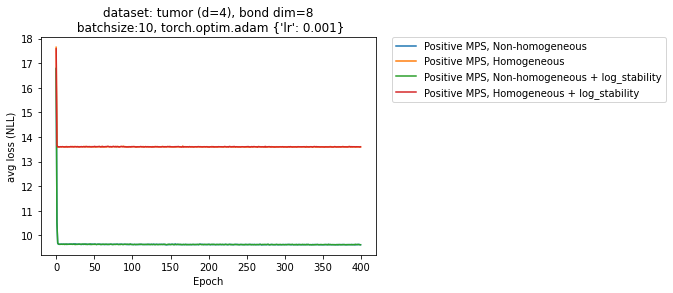

In [13]:
lossvals = train_models(
    [mps, mps_hom, mps_s, mps_s_hom], 
    clamp_at=1000, batchsize=10, max_epochs=400, batched=False, optimizer=torch.optim.Adam, lr=0.001)

dataset: tumor
╭───────────────────────────
│Training Born (torch.float32), Non-homogeneous + log_stability, on cpu
│         batchsize:40, torch.optim.adam, {'lr': 0.001}.



│ loss values: 8.003 7.967 7.922 7.975 7.940 7.899 7.890 7.904 7.911 7.874 7.890 7.955 7.889 7.896 7.851 7.881 7.863 7.854 7.886 7.881 7.847 7.893 7.848 7.925 7.798 7.893 7.821 7.879 7.828 7.864 7.779 7.833 7.853 7.861 7.851 7.749 7.833 7.859 7.863 7.804 7.863 7.832 7.830 7.784 7.758 7.837 7.802 7.857 7.773 7.785 7.786 7.821 7.733 7.789 7.746 7.789 7.767 7.771 7.758 7.824 7.728 7.774 7.724 7.780 7.784 7.758 7.779 7.763 7.709 7.715 7.703 7.734 7.662 7.736 7.689 7.739 7.737 7.698 7.727 7.653 7.714 7.668 7.690 7.708 7.694 7.709 7.654 7.705 7.721 7.669 7.641 7.703 7.650 7.677 7.656 7.669 7.667 7.702 7.724 7.641 7.656 7.626 7.653 7.618 7.673 7.624 7.638 7.590 7.612 7.636 7.634 7.647 7.612 7.636 7.649 7.560 7.593 7.634 7.605 7.602 7.612 7.618 7.609 7.620 7.577 7.637 7.595 7.551 7.573 7.597 7.584 7.605 7.525 7.575 7.610 7.535 7.526 7.579 7.529 7.540 7.542 7.549 7.519 7.553 7.580 7.540 7.524 7.571 7.545 7.516 7.517 7.571 7.542 7.542 7.522 7.559 7.550 7.561 7.529 7.553 7.520 7.532 7.492 7.518 


│ loss values: 7.747 7.744 7.719 7.694 7.702 7.685 7.691 7.663 7.708 7.630 7.653 7.648 7.660 7.701 7.689 7.643 7.650 7.690 7.671 7.671 7.676 7.681 7.669 7.650 7.677 7.662 7.637 7.590 7.661 7.609 7.652 7.606 7.591 7.645 7.601 7.624 7.605 7.651 7.565 7.620 7.604 7.528 7.609 7.587 7.571 7.598 7.565 7.591 7.608 7.579 7.590 7.560 7.587 7.534 7.570 7.578 7.570 7.600 7.532 7.503 7.539 7.522 7.558 7.532 7.536 7.516 7.545 7.547 7.480 7.552 7.507 7.481 7.531 7.509 7.525 7.531 7.446 7.486 7.522 7.479 7.502 7.493 7.495 7.484 7.495 7.482 7.470 7.511 7.532 7.537 7.460 7.481 7.469 7.498 7.483 7.493 7.426 7.451 7.519 7.460 7.461 7.491 7.477 7.437 7.423 7.452 7.398 7.446 7.436 7.357 7.446 7.465 7.463 7.434 7.417 7.424 7.426 7.425 7.478 7.482 7.429 7.411 7.382 7.422 7.440 7.436 7.428 7.377 7.359 7.408 7.494 7.409 7.362 7.407 7.374 7.394 7.484 7.379 7.356 7.410 7.400 7.396 7.340 7.362 7.363 7.437 7.377 7.407 7.387 7.355 7.374 7.330 7.338 7.398 7.338 7.379 7.344 7.385 7.354 7.328 7.328 7.336 7.341 7.339 


│ loss values: 8.135 8.077 8.107 8.056 8.062 8.087 8.117 8.110 8.070 8.039 8.065 8.061 8.079 8.068 8.038 8.084 8.037 8.066 8.063 8.060 8.037 8.100 8.025 8.070 8.076 8.023 8.039 8.021 8.046 8.038 8.029 8.002 8.015 7.990 8.085 8.019 7.971 7.990 8.044 7.982 8.021 7.970 8.039 8.036 8.010 8.011 8.024 7.961 8.020 7.969 8.049 7.985 7.963 7.997 7.976 7.972 7.954 7.946 7.910 7.988 7.933 7.969 7.991 7.947 7.975 7.975 7.990 7.958 7.980 7.936 7.957 7.919 7.950 7.915 7.925 7.919 7.900 7.977 7.913 7.907 7.946 7.902 7.924 7.946 7.930 7.929 7.922 7.952 7.932 7.878 7.929 7.905 7.884 7.890 7.916 7.916 7.878 7.904 7.895 7.902 7.873 7.878 7.884 7.875 7.896 7.931 7.911 7.942 7.928 7.937 7.837 7.857 7.843 7.848 7.860 7.876 7.888 7.831 7.883 7.862 7.888 7.871 7.833 7.845 7.808 7.786 7.853 7.807 7.824 7.822 7.829 7.781 7.828 7.804 7.867 7.777 7.875 7.816 7.825 7.775 7.785 7.833 7.824 7.761 7.823 7.769 7.805 7.759 7.779 7.758 7.782 7.814 7.788 7.774 7.802 7.737 7.728 7.772 7.764 7.734 7.742 7.733 7.780 7.788 


│ loss values: 8.330 8.298 8.308 8.297 8.285 8.322 8.276 8.281 8.258 8.230 8.251 8.235 8.222 8.240 8.217 8.273 8.231 8.227 8.217 8.246 8.232 8.247 8.206 8.228 8.197 8.206 8.188 8.195 8.225 8.173 8.257 8.285 8.171 8.134 8.177 8.197 8.221 8.134 8.182 8.199 8.166 8.134 8.178 8.118 8.141 8.148 8.154 8.159 8.126 8.134 8.147 8.168 8.146 8.105 8.157 8.167 8.100 8.114 8.082 8.085 8.095 8.144 8.103 8.091 8.122 8.083 8.105 8.127 8.050 8.123 8.049 8.125 8.079 8.073 8.108 8.022 8.127 8.089 8.096 8.072 8.056 8.075 8.075 8.061 8.079 8.080 8.046 8.057 8.067 7.992 8.023 8.083 8.071 8.077 8.059 8.046 8.032 7.997 8.061 8.031 7.980 8.050 8.009 8.005 8.069 8.031 8.074 8.025 7.947 8.023 8.101 7.997 7.963 7.997 7.989 7.973 8.007 7.995 8.043 8.029 7.967 8.003 8.049 7.943 7.983 7.952 7.964 7.928 8.023 7.966 7.941 7.982 7.957 7.963 7.939 7.953 8.014 7.981 7.933 7.983 8.002 7.947 7.986 7.944 7.914 7.957 7.921 7.967 7.933 7.880 7.973 7.960 7.980 7.929 7.952 7.939 7.916 7.917 7.875 7.914 7.949 7.897 7.928 7.950 


│ loss values: 9.608 9.632 9.593 9.538 9.581 9.537 9.673 9.634 9.656 9.599 9.562 9.562 9.564 9.570 9.663 9.639 9.532 9.563 9.553 9.586 9.653 9.612 9.590 9.584 9.606 9.585 9.587 9.596 9.561 9.658 9.651 9.649 9.610 9.573 9.619 9.606 9.637 9.548 9.616 9.638 9.587 9.579 9.629 9.599 9.579 9.651 9.598 9.560 9.630 9.606 9.567 9.632 9.577 9.624 9.597 9.619 9.609 9.576 9.630 9.594 9.570 9.603 9.604 9.627 9.540 9.569 9.567 9.660 9.557 9.624 9.632 9.644 9.641 9.685 9.621 9.621 9.633 9.635 9.592 9.658 9.618 9.606 9.581 9.565 9.574 9.647 9.528 9.660 9.624 9.614 9.613 9.592 9.613 9.577 9.588 9.566 9.632 9.557 9.581 9.608 9.589 9.626 9.631 9.643 9.555 9.648 9.582 9.580 9.584 9.663 9.607 9.546 9.614 9.594 9.590 9.620 9.604 9.644 9.576 9.630 9.615 9.617 9.590 9.636 9.580 9.595 9.554 9.602 9.693 9.651 9.586 9.603 9.626 9.563 9.657 9.605 9.641 9.613 9.587 9.571 9.541 9.576 9.624 9.598 9.618 9.612 9.642 9.581 9.609 9.647 9.618 9.556 9.583 9.561 9.593 9.621 9.621 9.555 9.669 9.591 9.602 9.648 9.552 9.610 


│ loss values: 13.617 13.535 13.610 13.571 13.649 13.595 13.527 13.627 13.666 13.600 13.574 13.583 13.565 13.606 13.650 13.489 13.623 13.603 13.584 13.552 13.620 13.577 13.642 13.685 13.540 13.603 13.569 13.593 13.552 13.549 13.562 13.620 13.583 13.605 13.528 13.619 13.565 13.601 13.603 13.620 13.552 13.554 13.549 13.526 13.552 13.640 13.584 13.527 13.591 13.571 13.544 13.553 13.642 13.675 13.689 13.610 13.636 13.670 13.603 13.580 13.581 13.647 13.544 13.542 13.565 13.541 13.623 13.611 13.648 13.557 13.641 13.597 13.577 13.607 13.579 13.602 13.612 13.600 13.584 13.567 13.596 13.563 13.603 13.574 13.576 13.562 13.545 13.574 13.519 13.533 13.579 13.639 13.608 13.535 13.675 13.589 13.570 13.561 13.578 13.596 13.529 13.526 13.594 13.550 13.581 13.662 13.631 13.520 13.576 13.636 13.636 13.664 13.607 13.610 13.532 13.552 13.588 13.591 13.599 13.602 13.559 13.577 13.652 13.645 13.633 13.578 13.587 13.499 13.570 13.631 13.565 13.476 13.527 13.597 13.574 13.558 13.577 13.577 13.623 13.610 13.5


│ loss values: 9.613 9.632 9.624 9.593 9.607 9.568 9.571 9.612 9.599 9.627 9.584 9.675 9.620 9.628 9.623 9.580 9.580 9.535 9.661 9.631 9.614 9.590 9.581 9.634 9.546 9.640 9.632 9.610 9.613 9.588 9.573 9.646 9.631 9.561 9.623 9.588 9.576 9.640 9.633 9.606 9.597 9.561 9.592 9.559 9.605 9.674 9.637 9.612 9.580 9.603 9.627 9.614 9.577 9.620 9.636 9.652 9.545 9.633 9.586 9.626 9.601 9.619 9.568 9.630 9.629 9.585 9.603 9.592 9.591 9.617 9.615 9.666 9.596 9.580 9.624 9.615 9.626 9.573 9.564 9.627 9.628 9.567 9.611 9.576 9.594 9.579 9.599 9.590 9.623 9.612 9.623 9.577 9.602 9.568 9.599 9.576 9.614 9.622 9.651 9.649 9.598 9.602 9.578 9.573 9.589 9.599 9.672 9.643 9.579 9.586 9.660 9.592 9.615 9.590 9.630 9.626 9.560 9.650 9.621 9.636 9.536 9.581 9.539 9.625 9.536 9.575 9.581 9.641 9.584 9.618 9.612 9.597 9.596 9.643 9.607 9.598 9.544 9.595 9.598 9.634 9.596 9.619 9.576 9.643 9.578 9.537 9.607 9.585 9.571 9.605 9.593 9.694 9.660 9.649 9.619 9.637 9.629 9.614 9.628 9.611 9.636 9.588 9.634 9.629 


│ loss values: 13.593 13.559 13.602 13.572 13.547 13.565 13.605 13.594 13.677 13.609 13.589 13.561 13.600 13.523 13.609 13.611 13.546 13.581 13.610 13.549 13.560 13.623 13.567 13.554 13.624 13.594 13.582 13.578 13.629 13.548 13.541 13.589 13.606 13.605 13.611 13.510 13.552 13.554 13.652 13.622 13.574 13.604 13.523 13.507 13.618 13.547 13.541 13.514 13.624 13.560 13.523 13.562 13.671 13.632 13.552 13.616 13.585 13.539 13.580 13.649 13.591 13.664 13.535 13.629 13.643 13.578 13.555 13.661 13.620 13.565 13.564 13.692 13.590 13.604 13.559 13.593 13.597 13.576 13.613 13.579 13.557 13.536 13.570 13.604 13.637 13.598 13.518 13.580 13.586 13.582 13.566 13.587 13.611 13.599 13.532 13.605 13.667 13.625 13.604 13.597 13.577 13.653 13.556 13.637 13.606 13.606 13.670 13.590 13.605 13.537 13.626 13.571 13.604 13.563 13.663 13.560 13.471 13.551 13.527 13.582 13.601 13.615 13.501 13.609 13.630 13.604 13.558 13.590 13.538 13.512 13.563 13.578 13.599 13.566 13.600 13.621 13.704 13.599 13.563 13.597 13.6

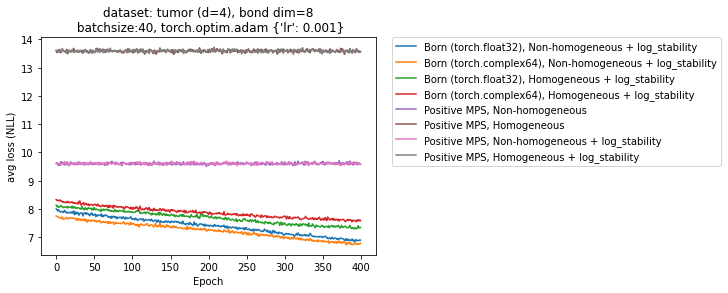

In [17]:
lossvals = train_models(
    [rBorn_s, cBorn_s,rBorn_s_hom, cBorn_s_hom, mps, mps_hom, mps_s, mps_s_hom], 
    clamp_at=1000, batchsize=40, max_epochs=400, batched=False, optimizer=torch.optim.Adam, lr=0.001)

## Useful things?

In [ ]:
# Testing item selection

d=6
bs=3
slen=5
D=2

X = torch.randint(d,(bs,slen))
print(X)
weights = torch.arange(bs*slen*d*D*D).view(bs,slen,d,D,D)#.type(torch.cfloat)
# print(weights)
# what we want to do is, 
# in the bth batch and the ith core, 
# choose the X[b,i]th weight element
print("Selected weight items:")
for b, _ in enumerate(weights):
    for i, _ in enumerate(weights[b]):
        print(weights[b,i,X[b,i]])
    print()

# using a one-hot encoding of X, a tensor Xh of shape [bs,slen,d]
Xh = torch.nn.functional.one_hot(X, num_classes=d)
print("weights' shape", weights.shape)
print("1hot obs shape", Xh.shape)
# for b,_ in enumerate(ww):
#     print((ww[b] * XXh[b][:, :,None,None]).sum(1))
selected = (weights * Xh[:, :, :, None, None]).sum(2)
print("Selected weight items:")
print(selected.shape)
print(selected)

In [ ]:
# # torch.autograd.set_detect_anomaly(True)
# def train(self, dataset, batchsize, max_epochs, plot=True, **optim_kwargs):
#     trainloader = DataLoader(dataset, batch_size=batchsize, shuffle=True)
#     optimizer = torch.optim.Adadelta(self.parameters(), **optim_kwargs)
#     early_stopping_threshold = 1e-6 # min difference in epoch loss 
#     loss_values = [] # store by-epoch avg loss values
#     print(f'╭───────────────────────────\n│Training {self.name},')
#     print(f'│         batchsize:{batchsize}, {optimizer.__module__}, {optim_kwargs}.')
#     av_batch_loss_running = -1e4
#     with tqdm(range(max_epochs), unit="epoch", leave=True) as tepochs:
#         for epoch in tepochs:
#             batch_loss_list = []
#             with tqdm(trainloader, unit="batch", leave=False, desc=f"epoch {epoch}") as tepoch:
#                 for batch in tepoch:
#                     for pindex, p in enumerate(self.parameters()):
#                         if torch.isnan(p).any():
#                             pnames = list(self.state_dict().keys())
#                             print("│ loss values:", *(f"{x:.3f}" for x in loss_values))
#                             print(f"└────Stopped before epoch {epoch}. NaN in weights {pnames[pindex]}!")
#                             if plot:
#                                 plt.plot(loss_values)
#                                 plt.show()
#                             return loss_values
#                     self.zero_grad()
#                     neglogprob = 0
#                     for x in batch:
#                         out = self(x)
#                         neglogprob -= out
#                     loss = neglogprob / len(batch)
#                     loss.backward()
#                     # for pindex, p in enumerate(self.parameters()):
#                     #     if torch.isnan(p.grad).any():
#                     #         pnames = list(self.state_dict().keys())
#                     #         print("│ loss values:", *(f"{x:.3f}" for x in loss_values))
#                     #         print(f"└────Stopped. NaN value in gradient for {pnames[pindex]}!")
#                     #         if plot:
#                     #             plt.plot(loss_values)
#                     #             plt.show()
#                     #         return loss_values
#                     optimizer.step()
#                     tepoch.set_postfix(loss=loss.item())
#                     batch_loss_list.append(loss.item())
#                 av_batch_loss = torch.Tensor(batch_loss_list).mean().item()
#                 loss_values.append(av_batch_loss)
#                 tepochs.set_postfix(av_batch_loss=av_batch_loss)
#                 if abs(av_batch_loss_running - av_batch_loss) < early_stopping_threshold:
#                     print(f"├────Early stopping after epoch {epoch}/{max_epochs}.")
#                     break
#                 av_batch_loss_running = av_batch_loss
#     print("│ loss values:", *(f"{x:.3f}" for x in loss_values))
#     if plot:
#         plt.plot(loss_values)
#         plt.show()
#     print('│ Finished training.\n╰───────────────────────────\n')
#     return loss_values

# def train_models(models, batchsize, max_epochs, **optim_kwargs):
#     print(f"dataset: {dataset}")
#     models_loss_values={}
#     for model in models:
#         loss_values = train(model, X, batchsize=batchsize, plot=False, max_epochs = max_epochs, **optim_kwargs)
#         plt.plot(loss_values, label=model.name)
#         plt.ylabel('avg loss (NLL)')
#         plt.xlabel('Epoch')
#         plt.title(f"dataset: {dataset} (d={d}), bond dim={D}\n batchsize:{batchsize}, {optim_kwargs}")
#         models_loss_values[f"{model.name}"]=loss_values
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#     plt.show()
#     return models_loss_values